In [1]:
# *****************************************************
# * Import required packages and set up path for ODYM *
# *****************************************************
import sys, os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from core.dataprovider import DataProvider
from core.datachecker import DataChecker
from core.datavisualizer import DataVisualizer
from core.network_graph import NetworkGraph
from core.flowsolver import FlowSolver
from core.parameters import ParameterName

# Path configuration
sys.path.insert(0, os.path.join('.'))
sys.path.insert(0, os.path.join(os.getcwd(), '.', 'lib', 'odym', 'modules'))

# ODYM classes
import ODYM_Classes as msc

In [2]:
# ******************************************************
# * Step 1: Load the data from Excel file DataProvider *
# ******************************************************

# Load data from file using the DataProvider
# and get model parameters from the file
filename = "data/example_data.xlsx"

print("Loading data from file {}...".format(filename))
dataprovider = DataProvider(filename)

# Model parameters is a Dictionary that contains loaded data from Excel sheet named "Settings"
# and are used for running the FlowSolver and setting up ODYM
model_params = dataprovider.get_model_params()
print("Using following parameters for running the model:")
for param_name, param_value in model_params.items():
    print("\t{:32}= {}".format(param_name, param_value))

# Setup output path
# NOTE: This only works inside Notebook, executable might need __file__?
rel_path_to_output = model_params[ParameterName.OutputPath]
abs_output_path = os.path.abspath(os.path.join(os.getcwd(), rel_path_to_output))
model_params[ParameterName.OutputPath] = abs_output_path

Loading data from file data/example_data.xlsx...
Using following parameters for running the model:
	sheet_name_processes            = Processes
	column_range_processes          = B:R
	skip_num_rows_processes         = 2
	sheet_name_flows                = Flows
	column_range_flows              = B:U
	skip_num_rows_flows             = 2
	start_year                      = 2021
	end_year                        = 2030
	detect_year_range               = False
	use_virtual_flows               = True
	virtual_flows_epsilon           = 0.1
	conversion_factor_c_to_co2      = 3.67
	fill_missing_absolute_flows     = True
	fill_missing_relative_flows     = True
	fill_method                     = Previous
	sheet_name_scenarios            = Scenarios
	create_network_graphs           = False
	create_sankey_charts            = True
	output_path                     = output


In [3]:
# **************************************************************
# * Step 2: Check data integrity and build data for FlowSolver *
# **************************************************************

print("Checking errors in data...")
data_checker = DataChecker(dataprovider)
scenarios = data_checker.build_scenarios()
is_checker_ok, checker_messages = data_checker.check_for_errors()
if not is_checker_ok:
    for msg in checker_messages:
        print(msg)
    SystemExit(-1)


# Create network graph for data
# scenarios[0] is always the baseline scenario and is guaranteed to exist
if model_params[ParameterName.CreateNetworkGraphs]:
    network_visualizer = NetworkGraph()
    network_visualizer.build(scenarios[0].scenario_data)
    network_visualizer.show()


Checking errors in data...
Checking stock distribution types...
Checking stock distribution parameters...
Checking process total inflows and total outflows mismatches...
Checking flow type changes...
Checking for processes that have no inflows and only relative outflows...
Checking scenario definitions...
Building baseline scenario...
Building 0 alternative scenarios...


In [4]:
# ******************************************************************
# * Step 3: Solve flows for baseline scenario using the FlowSolver *
# ******************************************************************
for scenario_index, scenario in enumerate(scenarios):
    # NOTE: Baseline scenario is always the first element in the list
    # and all the alternative scenarios (if any) are after that
    if scenario_index == 0:
        # Process baseline scenario
        baseline_flow_solver = FlowSolver(scenario=scenario)
        baseline_flow_solver.solve_timesteps()
        scenario.flow_solver = baseline_flow_solver
    else:
        # Get and copy solved scenario data from baseline scenario flow solver
        baseline_scenario_data = scenarios[0].flow_solver.get_solved_scenario_data()
        scenario.copy_from_baseline_scenario_data(baseline_scenario_data)

        # Solve this alternative scenario time steps
        scenario_flow_solver = FlowSolver(scenario=scenario)
        scenario_flow_solver.solve_timesteps()
        scenario.flow_solver = scenario_flow_solver


Solving flows for year 2030/2030: : 10it [00:00, 1249.72it/s]

Created 1 virtual processes and 1 virtual flows for year 2030
	- Virtual process ID 'VP_Construction:FI'
	- Virtual flow ID 'VP_Construction:FI Construction:FI'



In [5]:
# ****************************************************************************
# * Step 4: Setup ODYM classifications and index table for each Scenario *
# ****************************************************************************
for scenario_index, scenario in enumerate(scenarios):
    print("Building ODYM MFA for scenario '{}' ({}/{})...".format(scenario.name, scenario_index + 1, len(scenarios)))
    # NOTE: ODYM MFA is only used for mass balance check?

    # Track solid wood equivalent and carbon.
    # Dictionary of classifications enters the index table defined for the system.
    # The index table lists all aspects needed and assigns a classification and index letter to each aspect.
    scenario_data = scenario.scenario_data
    years = scenario_data.years

    model_time_start = scenario_data.start_year
    model_time_end = scenario_data.end_year
    model_elements = ['Solid wood equivalent', 'Carbon']
    model_years = years

    model_classifications = {
        'Time': msc.Classification(Name='Time', Dimension='Time', ID=1, Items=model_years),
        'Cohort': msc.Classification(Name='Age-cohort', Dimension='Time', ID=2, Items=model_years),
        'Element': msc.Classification(Name='Elements', Dimension='Element', ID=3, Items=model_elements),
    }

    index_table = pd.DataFrame({'Aspect': ['Time', 'Age-cohort', 'Element'],  # 'Time' and 'Element' must be present!
                                'Description': ['Model aspect "time"', 'Model aspect "age-cohort"', 'Model aspect "Element"'],
                                'Dimension': ['Time', 'Time', 'Element'],  # 'Time' and 'Element' are also dimensions
                                'Classification': [model_classifications[Aspect] for Aspect in ['Time', 'Cohort', 'Element']],
                                'IndexLetter': ['t', 'c', 'e' ]})  # Unique one letter (upper or lower case) indices to be used later for calculations.

    index_table.set_index('Aspect', inplace=True)  # Default indexing of IndexTable, other indices are produced on the fly
    index_table

    # ****************************
    # Initialize ODYM MFA system *
    # ****************************
    flow_solver = scenario.flow_solver
    mfa_system = msc.MFAsystem(Name='Wood product system', Geogr_Scope='Europe', Unit='Mm3',
                               ProcessList=[], FlowDict={}, StockDict={}, ParameterDict={},
                               Time_Start=model_time_start, Time_End=model_time_end, IndexTable=index_table,
                               Elements=index_table.loc['Element'].Classification.Items)

    # Get inflow values to stock
    year_index_to_year = dict(enumerate(model_years))
    unique_processes = flow_solver.get_unique_processes()
    unique_flows = flow_solver.get_unique_flows()

    # NOTE: These are not used anywhere
    # TODO: Export these as CSVs
    # # DataFrames for Processes, Flows and Flow values
    # print("Collecting processes to DataFrame...")
    # df_processes = flow_solver.get_processes_as_dataframe()
    # print("Collecting flows to DataFrame...")
    # df_flows = flow_solver.get_flows_as_dataframe()
    # print("Collecting evaluated flow values to DataFrame...")
    # df_flow_values = flow_solver.get_evaluated_flow_values_as_dataframe()

    print("Creating ODYM objects...")
    # Create ODYM objects

    print("Building ODYM processes...")
    odym_processes = []
    process_id_to_index = {}
    for process_id, process in unique_processes.items():
        process_index = len(odym_processes)
        process_id_to_index[process_id] = process_index
        new_process = msc.Process(ID=process_index, Name=process.name)
        odym_processes.append(new_process)

    print("Building ODYM flows...")
    odym_flows = {}
    for flow_id, flow in unique_flows.items():
        source_process_index = process_id_to_index[flow.source_process_id]
        target_process_index = process_id_to_index[flow.target_process_id]
        new_flow = msc.Flow(ID=flow.id, P_Start=source_process_index, P_End=target_process_index, Indices='t,e', Values=None)
        odym_flows[flow.id] = new_flow

    print("Building ODYM stocks...")
    odym_stocks = {}
    for stock in flow_solver.get_all_stocks():
        process_index = process_id_to_index[stock.id]
        new_stock = msc.Stock(ID=stock.id, Name=stock.name, P_Res=process_index, Indices='t,e', Type=0, Values=None)
        odym_stocks[stock.id] = new_stock

    mfa_system.ProcessList = odym_processes
    mfa_system.FlowDict = odym_flows
    mfa_system.StockDict = odym_stocks
    mfa_system.Initialize_FlowValues()
    mfa_system.Initialize_StockValues()
    mfa_system.Consistency_Check()

    # Update ODYM flow values from flow values DataFrame
    for flow_id, flow in mfa_system.FlowDict.items():
        for year_index, value in enumerate(flow.Values):
            # Skip to next year if FlowSolver does not have data for this year
            # This is possible because ODYM flow and stock values are already initialized to 0.0
            flow_has_data_for_year = flow_solver.has_flow(year=year_index_to_year[year_index], flow_id=flow_id)
            if not flow_has_data_for_year:
                continue

            # NOTE: Virtual flows use default value defined in Flow for carbon content (now 1.0).
            solved_flow = flow_solver.get_flow(year=year_index_to_year[year_index], flow_id=flow_id)
            flow.Values[year_index, 0] = solved_flow.evaluated_value
            flow.Values[year_index, 1] = solved_flow.evaluated_value_carbon

    # Process stocks (fill with data)
    for stock_id, stock in odym_stocks.items():
        # Calculate cohorts for "Solid wood equivalent"
        dsm_swe = flow_solver.get_dynamic_stocks_swe()[stock_id]
        swe_stock_by_cohort = dsm_swe.compute_s_c_inflow_driven()
        swe_outflow_by_cohort = dsm_swe.compute_o_c_from_s_c()
        swe_stock_total = dsm_swe.compute_stock_total()
        swe_stock_change = dsm_swe.compute_stock_change()
        stock.Values[:, 0] = swe_stock_change

        # Calculate cohorts for "Carbon"
        dsm_carbon = flow_solver.get_dynamic_stocks_carbon()[stock_id]
        carbon_stock_by_cohort = dsm_carbon.compute_s_c_inflow_driven()
        carbon_outflow_by_cohort = dsm_carbon.compute_o_c_from_s_c()
        carbon_stock_total = dsm_carbon.compute_stock_total()
        carbon_stock_change = dsm_carbon.compute_stock_change()
        stock.Values[:, 1] = carbon_stock_change

    print("Mass balance difference per year")
    mb = mfa_system.MassBalance()
    print("Mass balance result shape: {}".format(mb.shape))
    df_mass_balance = pd.DataFrame(columns=["Year", "Process 0", "Rest", "Abs difference"])
    for year_index, year in enumerate(model_years):
        # Calculate mass balance using the first element in MFA system (= base element)
        # Negative value in process 0 means that process 0 has no inflows so this mass
        # is coming from outside system boundaries
        p0 = np.sum(mb[year_index][0][0])
        rest = np.sum(mb[year_index][1:, 0])
        abs_diff = abs(p0) - abs(rest)
        df_mass_balance.loc[year_index] = np.array([year, p0, rest, abs_diff])
    df_mass_balance = df_mass_balance.astype({"Year": "int32"})
    df_mass_balance.set_index(["Year"], inplace=True)

    # Show mass balance information for scenario
    # TODO: Export mass balance?
    print(df_mass_balance)

# ************************************************
# * Create output directory for scenario results *
# ************************************************

# If exists then delete existing directory and create new
if os.path.exists(model_params[ParameterName.OutputPath]):
    try:
        shutil.rmtree(model_params[ParameterName.OutputPath])
    except Exception as ex:
        print(ex)

# Create output directory and directories for all scenarios
os.makedirs(model_params[ParameterName.OutputPath])
for scenario in scenarios:
    os.makedirs(os.path.join(model_params[ParameterName.OutputPath], scenario.name))

Building ODYM MFA for scenario 'Baseline' (1/1)...
Creating ODYM objects...
Building ODYM processes...
Building ODYM flows...
Building ODYM stocks...
Mass balance difference per year
Mass balance result shape: (10, 10, 2)
      Process 0  Rest  Abs difference
Year                                 
2021      -60.0  60.0    0.000000e+00
2022      -60.0  60.0    0.000000e+00
2023      -60.0  60.0    0.000000e+00
2024      -60.0  60.0    0.000000e+00
2025      -60.0  60.0    0.000000e+00
2026      -60.0  60.0    0.000000e+00
2027      -60.0  60.0    7.105427e-15
2028      -60.0  60.0    0.000000e+00
2029      -60.0  60.0   -7.105427e-15
2030      -60.0  60.0    0.000000e+00


Show dynamic stock results...


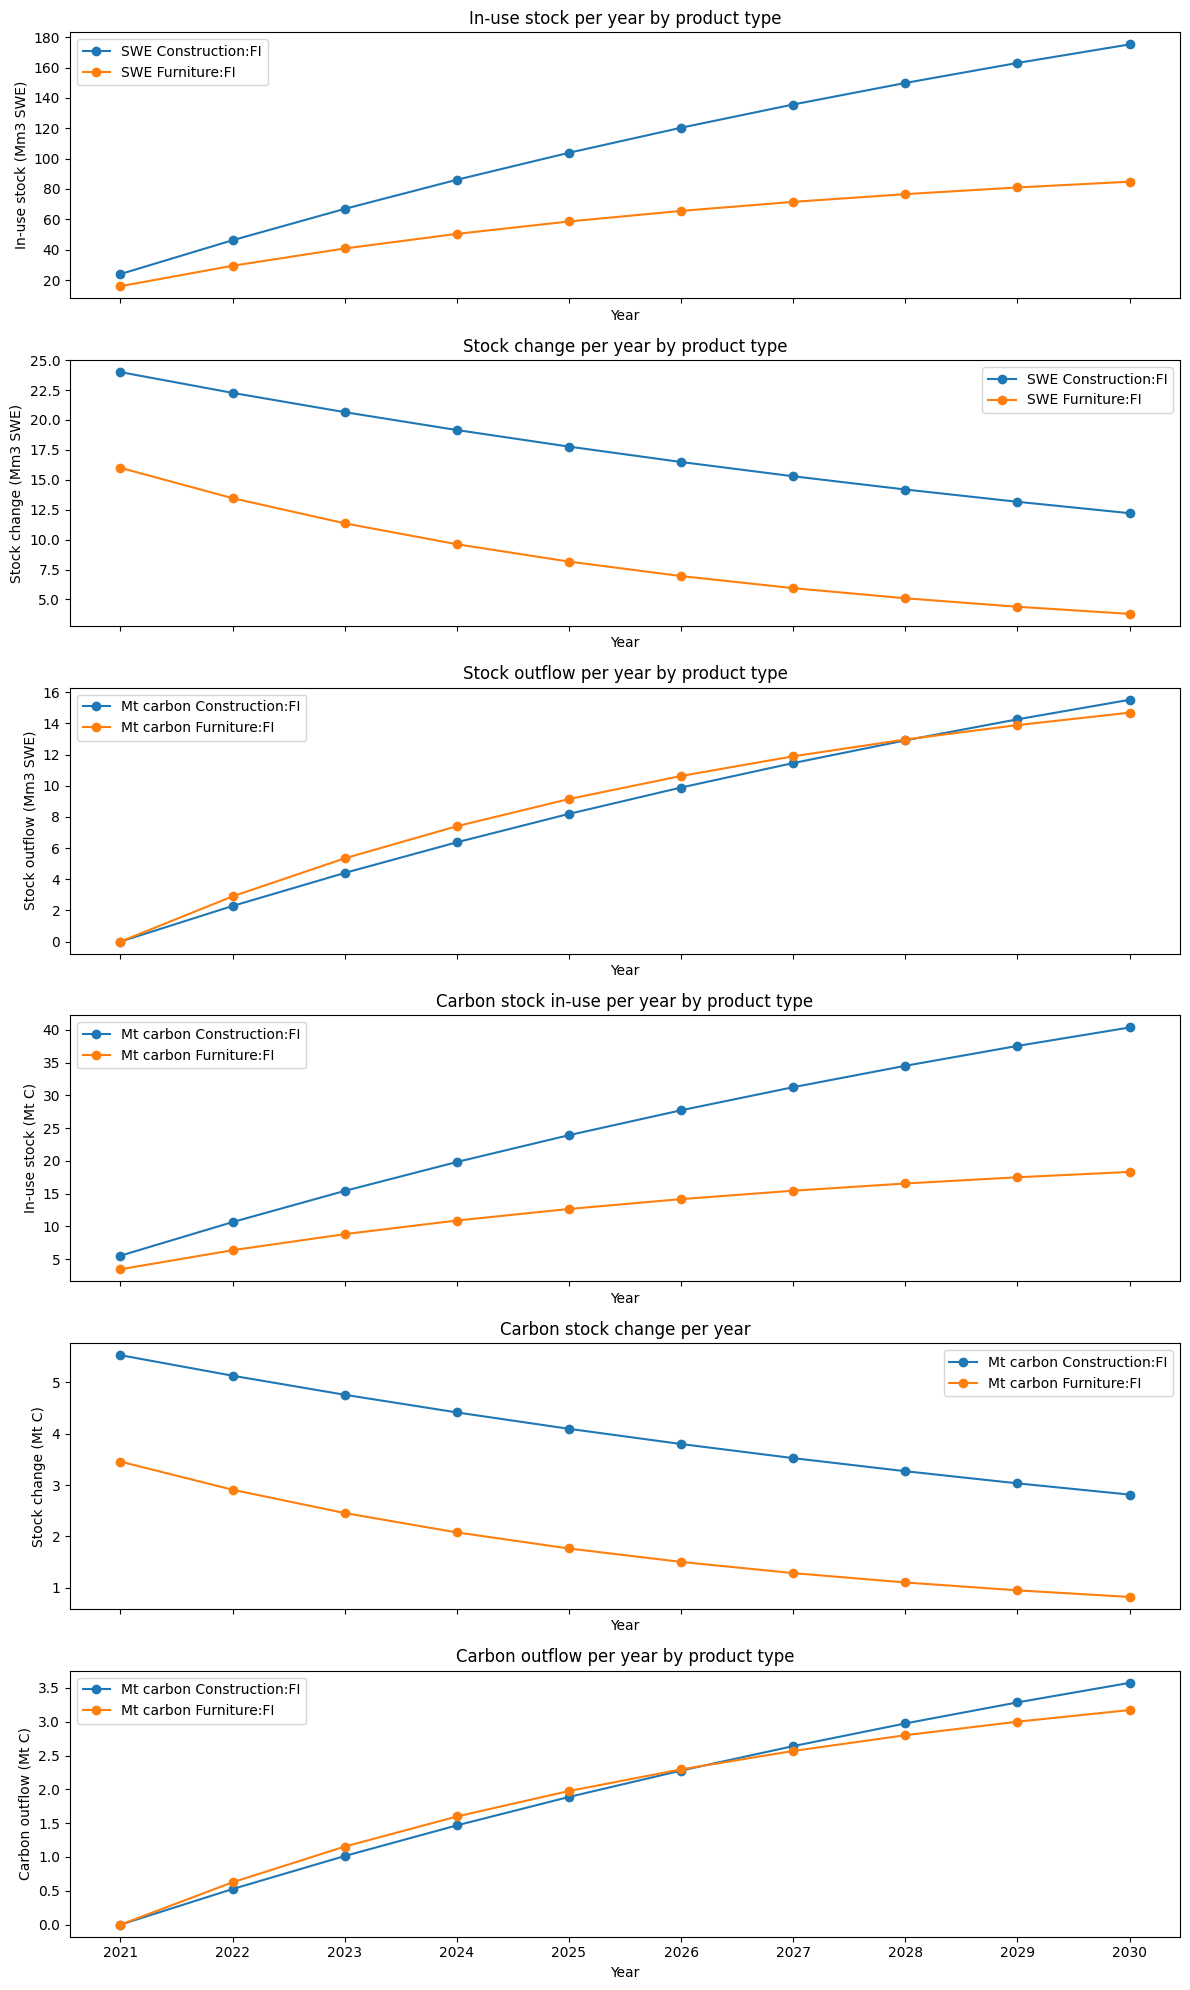

In [6]:
# *****************************************************
# * Step 5: Plot the dynamic stocks results *
# *****************************************************
print("Show dynamic stock results...")
for scenario in scenarios:
    # stock_id_to_dsm_swe and stock_id_to_dsm_carbon are dictionaries containing DynamicStockModel instances
    flow_solver = scenario.flow_solver
    stock_id_to_dsm_swe = flow_solver.get_dynamic_stocks_swe()
    stock_id_to_dsm_carbon = flow_solver.get_dynamic_stocks_carbon()

    if not len(stock_id_to_dsm_swe.keys()):
        print("Scenario '{}': no dynamic stocks in the defined system".format(scenario.name))
        continue

    fig, axes = plt.subplots(6, 1, sharex='all', sharey='none', figsize=(12, 20))

    # Visualize stocks
    for stock_id in stock_id_to_dsm_swe.keys():
        # SWE Stock
        dsm_swe = stock_id_to_dsm_swe[stock_id]
        swe_stock_by_cohort = dsm_swe.compute_s_c_inflow_driven()
        swe_oc = dsm_swe.compute_o_c_from_s_c()
        swe_stock_total = dsm_swe.compute_stock_total()
        swe_stock_change = dsm_swe.compute_stock_change()
        swe_o = dsm_swe.compute_outflow_total()

        # Carbon stock
        dsm_carbon = stock_id_to_dsm_carbon[stock_id]
        carbon_stock_by_cohort = dsm_carbon.compute_s_c_inflow_driven()
        carbon_oc = dsm_carbon.compute_o_c_from_s_c()
        carbon_stock_total = dsm_carbon.compute_stock_total()
        carbon_stock_change = dsm_carbon.compute_stock_change()
        carbon_o = dsm_carbon.compute_outflow_total()

        # Plot SWE stock total (in-use stocks)
        axes[0].plot(years, swe_stock_total, marker='o', label=f'SWE {stock_id}')
        axes[0].set_ylabel("In-use stock (Mm3 SWE)")
        axes[0].set_title("In-use stock per year by product type")

        # Plot SWE stock change
        axes[1].plot(years, swe_stock_change, marker='o', label=f'SWE {stock_id}')
        axes[1].set_ylabel("Stock change (Mm3 SWE)")
        axes[1].set_title("Stock change per year by product type")

        # Plot SWE outflow by cohort
        axes[2].plot(years, swe_o, marker='o', label=f'Mt carbon {stock_id}')
        axes[2].set_ylabel("Stock outflow (Mm3 SWE)")
        axes[2].set_title("Stock outflow per year by product type")

        # Plot Carbon stock total (in-use stocks)
        axes[3].plot(years, carbon_stock_total, marker='o', label=f'Mt carbon {stock_id}')
        axes[3].set_ylabel("In-use stock (Mt C)")
        axes[3].set_title("Carbon stock in-use per year by product type")

        # Plot Carbon stock change
        axes[4].plot(years, carbon_stock_change, marker='o', label=f'Mt carbon {stock_id}')
        axes[4].set_ylabel("Stock change (Mt C)")
        axes[4].set_title("Carbon stock change per year")

        # Plot carbon outflow by cohort
        axes[5].plot(years, carbon_o, marker='o', label=f'Mt carbon {stock_id}')
        axes[5].set_ylabel("Carbon outflow (Mt C)")
        axes[5].set_title("Carbon outflow per year by product type")

    # Set common properties to axes
    range_x_ticks = range(min(years), max(years) + 1)
    for axis in axes:
        axis.set_xlabel("Year")
        axis.title.set_size(12)
        axis.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    tick_gap = 1 if len(years) < 15 else 10
    plt.xticks(years[::tick_gap])

    # Save the figure as an SVG file
    output_path = os.path.join(model_params[ParameterName.OutputPath], scenario.name)
    filename = "{}_stock_plots_by_product.svg".format(scenario.name)
    abs_path_to_file = os.path.join(output_path, filename)
    plt.savefig(abs_path_to_file, format='svg')
    plt.show()


Show CO2 removals graphs...


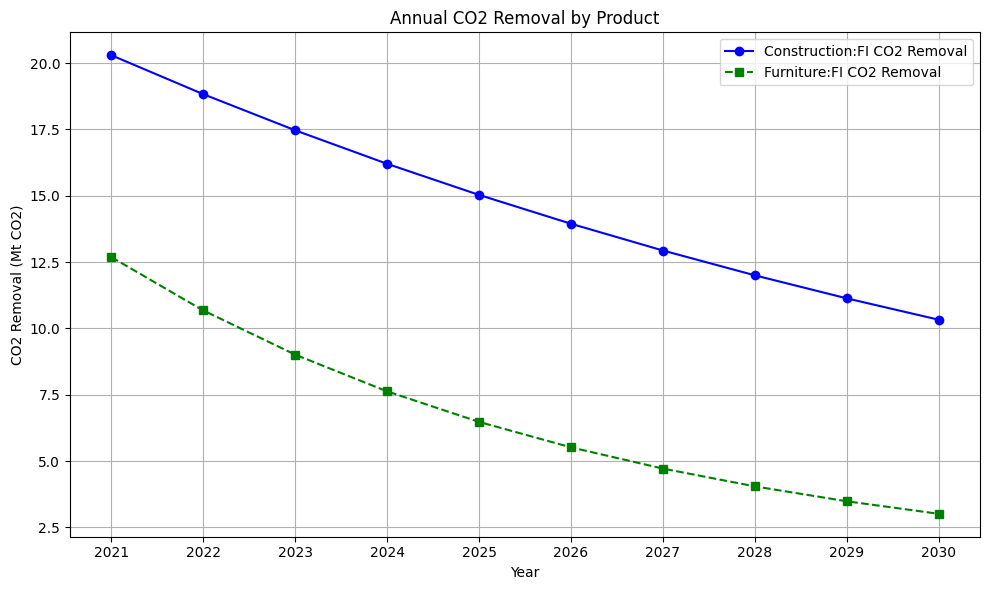

Annual CO2 removals (Mt) by stock:

      Construction:FI  Furniture:FI
Year                               
2021        20.293632     12.683520
2022        18.825924     10.674067
2023        17.464366      9.007915
2024        16.201281      7.624351
2025        15.029547      6.473554
2026        13.942556      5.514635
2027        12.934181      4.714023
2028        11.998735      4.044143
2029        11.130944      3.482339
2030        10.325914      3.009985


In [7]:
# *****************************************************
# * Step 6: Convert the carbon stocks to CO2 removals *
# *****************************************************
print("Show CO2 removals graphs...")
for scenario in scenarios:
    scenario_data = scenario.scenario_data
    flow_solver = scenario.flow_solver
    years = scenario_data.years
    year_start = scenario_data.start_year

    # Calculate CO2 removals for each stock and plot the results
    stock_id_to_dsm_carbon = flow_solver.get_dynamic_stocks_carbon()
    if not len(stock_id_to_dsm_carbon.keys()):
        print("Scenario '{}': no dynamic stocks in the defined system".format(scenario.name))
        continue

    results_co2_removals = pd.DataFrame({'Year': years})
    conversion_factor_c_to_co2 = model_params[ParameterName.ConversionFactorCToCO2]

    # Define line styles, markers, and colors for differentiation
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', '^', 'D']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    plt.figure(figsize=(10, 6))
    for index, (stock_id, dsm_carbon) in enumerate(stock_id_to_dsm_carbon.items()):
        total_inflows_carbon = dsm_carbon.i
        total_outflows_carbon = dsm_carbon.o
        annual_co2_removal = (total_inflows_carbon - total_outflows_carbon) * conversion_factor_c_to_co2
        results_co2_removals[stock_id] = annual_co2_removal

        line_style = line_styles[index % len(line_styles)]
        marker = markers[index % len(markers)]
        color = colors[index % len(colors)]
        plt.plot(years, results_co2_removals[stock_id], marker=marker, linestyle=line_style, color=color, label=f'{stock_id} CO2 Removal')

    plt.xlabel('Year')
    plt.ylabel('CO2 Removal (Mt CO2)')
    plt.title('Annual CO2 Removal by Product')
    plt.grid(True)
    tick_gap = 1 if len(years) < 15 else 10
    plt.xticks(years[::tick_gap])
    plt.legend()
    plt.tight_layout()

    # Save the figure as an SVG file
    output_path = os.path.join(model_params[ParameterName.OutputPath], scenario.name)
    filename = "{}_annual_co2_removal_by_product.svg".format(scenario.name)
    abs_path_to_file = os.path.join(output_path, filename)
    plt.savefig(abs_path_to_file, format='svg')
    plt.show()

    print("Annual CO2 removals (Mt) by stock:\n")
    results_co2_removals.set_index("Year", inplace=True)
    print(results_co2_removals)



Source process ID: Construction:FI, Input value: 0.0, Year: 2021
Source process ID: Furniture:FI, Input value: 0.0, Year: 2021
Source process ID: Construction:FI, Input value: 1.3703411802821819, Year: 2022
Source process ID: Furniture:FI, Input value: 2.900307950752291, Year: 2022
Source process ID: Construction:FI, Input value: 2.6415744048500143, Year: 2023
Source process ID: Furniture:FI, Input value: 5.341119453770032, Year: 2023
Source process ID: Construction:FI, Input value: 3.820867514112301, Year: 2024
Source process ID: Furniture:FI, Input value: 7.400936357565062, Year: 2024
Source process ID: Construction:FI, Input value: 4.9148699447255435, Year: 2025
Source process ID: Furniture:FI, Input value: 9.144377022096265, Year: 2025
Source process ID: Construction:FI, Input value: 5.929750222399988, Year: 2026
Source process ID: Furniture:FI, Input value: 10.624667909442174, Year: 2026
Source process ID: Construction:FI, Input value: 6.871230743092452, Year: 2027
Source process 

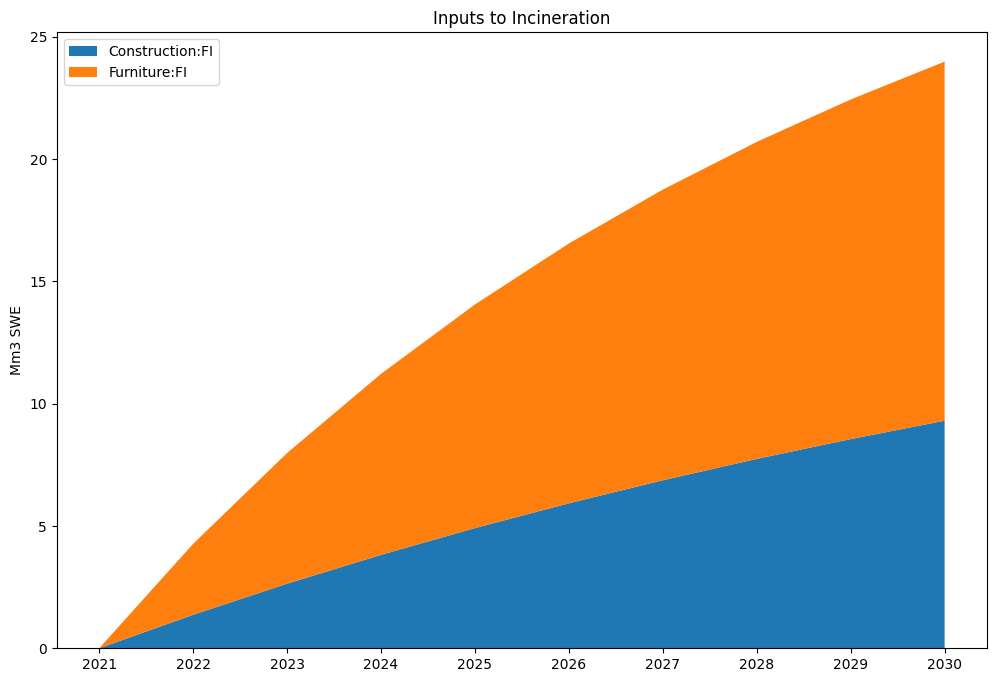

Source process ID: Industrial_roundwood:FI, Input value: 60.0, Year: 2021
Source process ID: Construction:FI, Input value: 0.0, Year: 2021
Source process ID: Industrial_roundwood:FI, Input value: 60.0, Year: 2022
Source process ID: Construction:FI, Input value: 0.9135607868547879, Year: 2022
Source process ID: Industrial_roundwood:FI, Input value: 60.0, Year: 2023
Source process ID: Construction:FI, Input value: 1.7610496032333431, Year: 2023
Source process ID: Industrial_roundwood:FI, Input value: 60.0, Year: 2024
Source process ID: Construction:FI, Input value: 2.5472450094082006, Year: 2024
Source process ID: Industrial_roundwood:FI, Input value: 60.0, Year: 2025
Source process ID: Construction:FI, Input value: 3.276579963150363, Year: 2025
Source process ID: Industrial_roundwood:FI, Input value: 60.0, Year: 2026
Source process ID: Construction:FI, Input value: 3.9531668149333252, Year: 2026
Source process ID: Industrial_roundwood:FI, Input value: 60.0, Year: 2027
Source process ID:

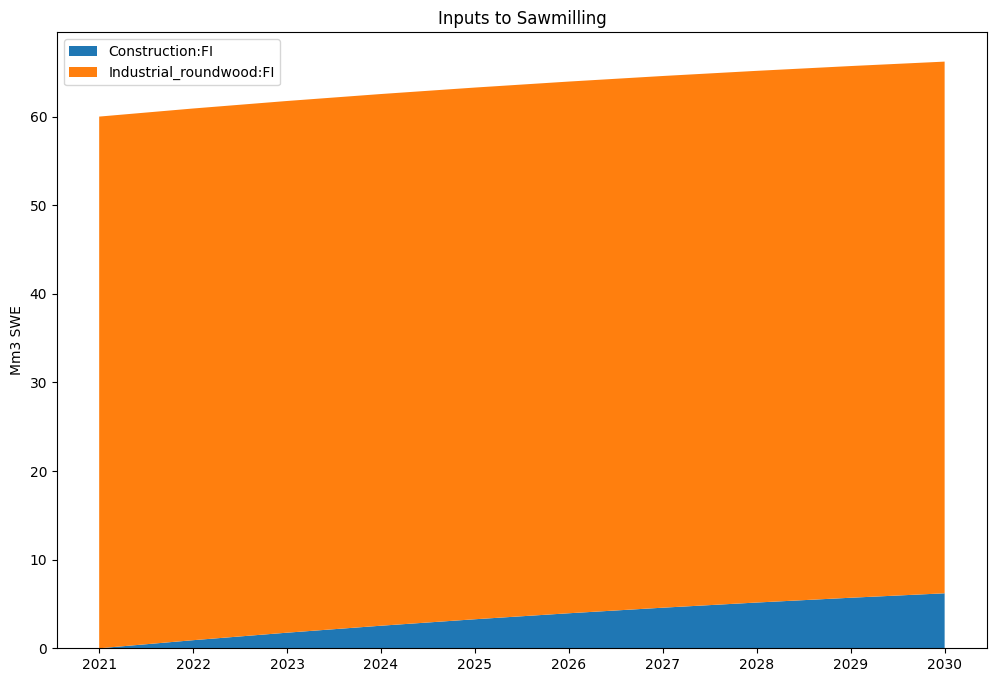

In [8]:
# ************************************************************
# * Step 7: Visualize inflows per year to selected processes *
# ************************************************************
# Visualize inflows per year to processes
process_ids_to_visualize = ["Incineration:FI", "Sawmilling:FI"]
for scenario in scenarios:
    flow_solver = scenario.flow_solver
    for process_id in process_ids_to_visualize:
        # Ignore visualizing inflows for processes that do not exist in this graph
        if process_id not in unique_processes:
            continue

        flow_id_to_source_process_id = {}
        source_process_names = []

        # Find all source processes of all incoming flows to this process in all years
        # This is needed to create stable set of process names so that the relative
        # position of the processes stay the same in stacked chart between the years
        source_process_ids = set()
        for year in years:
            inflows = flow_solver.get_process_flows(process_id, year)["Inflows"]
            unique_flow_ids = set()
            for flow in inflows:
                unique_flow_ids.add(flow.id)
                flow_id_to_source_process_id[flow.id] = flow.source_process_id

            # Find source process ID of each incoming flow and add
            # to list of unique source process IDs if not already there
            unique_flow_ids = list(unique_flow_ids)
            for flow_id in unique_flow_ids:
                source_process_ids.add(flow_id_to_source_process_id[flow_id])

        # Now source_process_ids-list contains list of all the possible process IDs
        # that have flows incoming to process_id. This list is needed to keep the
        # incoming process IDs the same every year because aiphoria allows the connections
        # between the flows to change between the years.
        source_process_ids = list(source_process_ids)

        # Create 2D array with shape of (number of source process IDs, number of years)
        # and fill with the value of the inflow from source process for each year
        source_process_by_flow_values = np.ndarray(shape=(len(source_process_ids), len(years)))
        for year_index, year in enumerate(years):
            inflows = flow_solver.get_process_flows(process_id, year)["Inflows"]
            for flow in inflows:
                source_process_id_index = source_process_ids.index(flow.source_process_id)
                source_process_by_flow_values[source_process_id_index, year_index] = flow.evaluated_value
                print(f"Source process ID: {flow.source_process_id}, Input value: {flow.evaluated_value}, Year: {year}")

        # Get the process name for the currently visualized process
        process = flow_solver.get_process(process_id, min(years))

        # Initialize the figure and axes for the stacked area chart
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.stackplot(years, source_process_by_flow_values, labels=list(source_process_ids))
        ax.set_ylabel("Mm3 SWE")
        ax.set_title("Inputs to {}".format(process.name))
        ax.legend(loc='upper left')
        tick_gap = 1 if len(years) < 15 else 10
        plt.xticks(years[::tick_gap])

        # Save the figure as an SVG file
        output_path = os.path.join(model_params[ParameterName.OutputPath], scenario.name)
        filename = "{}_inflows_to_processes_{}.svg".format(scenario.name, process.name)
        abs_path_to_file = os.path.join(output_path, filename)
        plt.savefig(abs_path_to_file, format='svg')
        plt.show()


In [9]:
# *****************************************************
# * Step 8: Visualize the flow graph as Sankey graph *
# *****************************************************

# Color mappings
process_transformation_stage_colors = dict()
process_transformation_stage_colors["Source"] = "#7DDA60"
process_transformation_stage_colors["First"] = "#eb5e34"
process_transformation_stage_colors["Second"] = "#8c76cf"
process_transformation_stage_colors["Third"] = "#5BAA11"
process_transformation_stage_colors["VAM"] = "#3281db"
process_transformation_stage_colors["RoW"] = "#61b053"  # Rest of the world
process_transformation_stage_colors["EoL"] = "#EFC3CA"  # Brown
process_transformation_stage_colors["by_prod"] = "#DFC57B"  # gold
process_transformation_stage_colors["Virtual"] = "#707070"
process_transformation_stage_colors["Other"] = "#707070"

# Label overrides
virtual_process_graph_labels = dict()
virtual_process_graph_labels["VP_P2:EU"] = "Unreported flow from P2"
virtual_process_graph_labels["VP_P3:EU"] = "Unreported flow from P3"

# Virtual Process and virtual Flow colors
visualizer_params = {
    # User can hide processes in Sankey graph that have total inflows less than this value
    # This value cannot be changed now in the Sankey graph
    "small_node_threshold": 5,

    # Dictionary to define labels for virtual flows
    # If dictionary contains label for the virtual process then that is used,
    # otherwise the virtual process ID is used
    "virtual_process_graph_labels": virtual_process_graph_labels,

    # Dictionary to define color of process by the process transformation stage name
    # All must be provided as a RGB hex string, prefixed by character '#'
    # Usage example: { "Source": "#707070" }
    "process_transformation_stage_colors": process_transformation_stage_colors,

    # How transparent flows are (0.0 = invisible, 1.0 = fully opaque)
    "flow_alpha": 0.75,

    # Color for virtual process
    "virtual_process_color": "rgba(0.3, 0.3, 0.3, 0.6)",
    #"virtual_process_color": "#707070",

    # Color for virtual flows
    #"virtual_flow_color": "rgba(0.5, 0.5, 0.5, 0.5)",
    "virtual_flow_color": "#808080",
}

# # NOTE: Now each scenario is in it's own graph
if model_params[ParameterName.CreateSankeyCharts]:
    visualizer = DataVisualizer()
    visualizer.build_and_show(scenarios, visualizer_params, model_params)